In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Dataclasses and typing
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

# scikit-learn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers as L, Model
from tensorflow.keras.layers import SeparableConv1D, MaxPooling1D, BatchNormalization, GRU, Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [ ]:


# file_path= ...set file path to your desired filepath after downloading dataset from github
df = pd.read_csv(file_path)

print(df.shape)



Mounted at /content/drive
(21782, 4229)


In [ ]:
# Helper functions for input spectra preprocessing after LED degradation


def reflectance_to_absorbance(R):
    R = np.asarray(R, dtype=np.float32)

    # ensure any zero values dont exist for log to work correctly
    R = np.clip(R, 1e-6, None)
    return -np.log10(R)

# Normalize each sample with Standard Normal Variate (SNV)
# This removes scatter effects and differences in overall light intensity
# for that sample, while keeping the relative shape of the spectrum.
def standard_normal_variate_rows(A):
    A = np.asarray(A, dtype=np.float32)
    row_means = A.mean(axis=1, keepdims=True)
    row_stds  = A.std(axis=1, keepdims=True) + EPS
    return (A - row_means) / row_stds




In [ ]:

BINS   = [0, 2, 5, 10, 20, np.inf]
LABELS = ["0-2", "2-5", "5-10", "10-20", "20+"]

MIXUP_ALPHA = 0.4 # ensures a light mix between samples, i.e 90% from sample 1 + 10% from sample 2
NOISE_SIGMA = 0.02
RNG = np.random.default_rng(42)

# Helpers

# add_gaussian_noise adds random noise to increase training data variation in generated spectra during data augmentation
def add_gaussian_noise(X, sigma=NOISE_SIGMA, rng=RNG):
    std = X.std(axis=1, keepdims=True) + 1e-8
    return X + rng.standard_normal(X.shape) * (sigma * std)

# mixup_multi creates n_new samples and scalars(N,EC and pH) using a scaled linear combination of two samples from X by [lam, 1-lam], aka linear mixup model.
def mixup_multi(X, targets_dict=None, alpha=0.4, n_new=0, rng=np.random.default_rng()):

  # Handle case where n_new=0, when the X being evaluated corresponds to the largest nitrogen bin
    n = len(X)
    if n == 0 or n_new == 0:
        emptyX = np.empty((0, X.shape[1]))
        empty_targets = {}
        if targets_dict:
            for k, v in targets_dict.items():
                v = np.asarray(v)
                empty_targets[k] = np.empty((0,) + v.shape[1:])
        return emptyX, empty_targets

    # Get two lits of indices from X to linearly combine, probability of same index being chosen is quite low
    i1 = rng.integers(0, n, size=n_new)
    i2 = rng.integers(0, n, size=n_new)

    # Get a list of uniformly chosen mixing coefficients from a clustered distribution dictated by alpha
    lam = rng.beta(alpha, alpha, size=n_new)          # (n_new,)

    # Make a (n_new, 2) weight matrix: [lam, 1-lam] for scaled mixing
    # Reshape it such that we can broadcast it on all chosen X pairs
    W = np.stack([lam, 1.0 - lam], axis=1)            # (n_new, 2)

    # Synthesis of each sample follows the following equation:
    # X_synth[i]=lam*X[i1]+(1-lam)*X[i2]
    # simply put it generates a list of synthesized samples that are generated by combining X at all indices i1 and i2 scaled by corresponding
    # lam, 1-lam
    X_pair = np.stack([X[i1], X[i2]], axis=1)
    X_synth = (W[:, :, None] * X_pair).sum(axis=1)

    # Similarly all target scalars are also generated using a linear combinations of the scalars picked in X at indices i1 and i2
    # and output as a dictionary to make parsing easier
    targ_out = {}
    if targets_dict:
        for k, y in targets_dict.items():
            y = np.asarray(y)
            y_pair = np.stack([y[i1], y[i2]], axis=1)
            mix = (W[(...,) + (None,)* (y_pair.ndim - 2)] * y_pair)
            targ_out[k] = mix.sum(axis=1)

    return X_synth, targ_out

# This function serves to split the raw dataset into train, validation and split datasets for model training
# Then the training dataset is split into different bins by their soil nitrogen value
# As large nitrogen value samples and spectra are rare in the dataset they are augmented through a linear mixup model
# All the bins with less samples than the bin with the largest amount of samples are augmented
# Thus the inputs: IR spectra, EC and pH values and the output Nitrogen values are generated using a linear mixup model
# We only augment the training data because we want to test the model on the real data which preserves the natural distribution of N, which would
# be altered by the augmentation otherwise
def make_augmented_splits(
    df,
    N_col="N",
    EC_col="EC",
    pH_col="pH(H2O)",
    # split sizes
    test_size=0.10,
    val_size=0.10,
    random_state=42,
    # augmentation knobs
    bins=BINS,
    labels=LABELS,
    mixup_alpha=MIXUP_ALPHA,
    noise_sigma=NOISE_SIGMA,
):
    # Separate all the columns containing IR spectra values, fortunately in the LUCAS dataset they are the only columns that have a purely numerical title

    spec_cols = [col for col in df.columns if not any(char.isalpha() for char in col)]

    # Clean & extract arrays while dropping rows with NaNs
    needed = [N_col, EC_col, pH_col] + spec_cols
    d = df[needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    # We clip X to start from 500 nm onwards, previous statistical analysis has shown that 400-500 nm datapoints are not important
    X = d[spec_cols].iloc[:, 200:].to_numpy(dtype=float)
    N = d[N_col].to_numpy(dtype=float)
    EC = d[EC_col].to_numpy(dtype=float)
    pH = d[pH_col].to_numpy(dtype=float)

    # Split nitrogen data values into buckets defined by BINS
    # This lets us split the data into train, val and test sets while preserving the statistical distribution of nitrogen values in the data
    # using stratification
    N_bucket = pd.cut(N, bins=BINS, labels=LABELS, right=False)
    idx = np.arange(len(d))

    # Split test first from train+val data
    idx_trv, idx_test = train_test_split(
        idx,
        test_size=test_size,
        random_state=random_state,
        stratify=N_bucket[idx]
    )

    # Split val from the remaining train+val data
    rel_val = val_size / (1.0 - test_size)
    idx_train, idx_val = train_test_split(
        idx_trv,
        test_size=rel_val,
        random_state=random_state,
        stratify=N_bucket[idx_trv]
    )

    # Assemble outputs
    X_train, N_train, EC_train, pH_train = X[idx_train], N[idx_train], EC[idx_train], pH[idx_train]
    X_val,   N_val,   EC_val,   pH_val   = X[idx_val],   N[idx_val],   EC[idx_val],   pH[idx_val]
    X_test,  N_test,  EC_test,  pH_test  = X[idx_test],  N[idx_test],  EC[idx_test],  pH[idx_test]

    # We now augment the training data only
    # We find which nitrogen bin in N train has the most samples and make it our target number of synthesized sample per bin
    # We then calculate the deficit between each bin # of samples and max count to generate a list of # of needed synthesis per bin
    train_buckets = pd.cut(N_train, bins=BINS, labels=LABELS, right=False)
    bucket_to_idx = {lab: np.where(train_buckets == lab)[0] for lab in labels}
    counts = {lab: len(bucket_to_idx[lab]) for lab in labels}
    target = max(counts.values()) if counts else 0
    deficit = {lab: max(0, target - counts[lab]) for lab in labels}

    # Separate original data
    parts_X   = [X_train]
    parts_N   = [N_train]
    parts_EC  = [EC_train]
    parts_pH  = [pH_train]
    synth_mask= [np.zeros(len(X_train), dtype=bool)]

    # We synthesize the deficit # samples for each bin using mixup multi combining, with gaussian noise for data variation
    for lab in labels:
        need = deficit[lab]
        if need <= 0 or counts[lab] == 0:
            continue
        ii = bucket_to_idx[lab]
        X_bin = X_train[ii]
        targ  = {"N": N_train[ii], "EC": EC_train[ii], "pH": pH_train[ii]}
        X_s, t_s = mixup_multi(X_bin, targ, alpha=mixup_alpha, n_new=need, rng=RNG)
        X_s = add_gaussian_noise(X_s, sigma=noise_sigma, rng=RNG)


        parts_X.append(X_s)
        parts_N.append(t_s["N"])
        parts_EC.append(t_s["EC"])
        parts_pH.append(t_s["pH"])
        synth_mask.append(np.ones(need, dtype=bool))

    X_train_aug  = np.vstack(parts_X)
    N_train_aug  = np.concatenate(parts_N)
    EC_train_aug = np.concatenate(parts_EC)
    pH_train_aug = np.concatenate(parts_pH)
    train_synth_mask = np.concatenate(synth_mask)



    return (
        X_train_aug, N_train_aug, EC_train_aug, pH_train_aug, train_synth_mask,
        X_val, N_val, EC_val, pH_val,
        X_test, N_test, EC_test, pH_test
    )

# Dataset generation
(
  X_train_aug, N_train_aug, EC_train_aug, pH_train_aug, train_synth_mask,
   X_val, N_val, EC_val, pH_val,
   X_test, N_test, EC_test, pH_test
 ) = make_augmented_splits(
    df,
     spectral_slice_from=200,
     test_size=0.10,
     val_size=0.10,
    random_state=42
 )

'\nplt.plot(raw_spectra[0])\n\nimport numpy as np\nfrom sklearn.cluster import KMeans\n\n# --- Run KMeans on raw reflectance ---\nkmeans = KMeans(n_clusters=2, n_init=20, random_state=42)\nlabels = kmeans.fit_predict(raw_spectra)\n\n# --- Decide which cluster is organic vs mineral ---\nmean_reflectance = raw_spectra.mean(axis=1)\ncluster0_mean = mean_reflectance[labels == 0].mean()\ncluster1_mean = mean_reflectance[labels == 1].mean()\n\norganic_cluster = 0 if cluster0_mean < cluster1_mean else 1\nmineral_cluster = 1 - organic_cluster\n\n# --- Get indices ---\norganic_indices = np.where(labels == organic_cluster)[0]\nmineral_indices = np.where(labels == mineral_cluster)[0]\n\nprint(f"Organic samples: {len(organic_indices)}")\nprint(f"Mineral samples: {len(mineral_indices)}")\n\n# You can now slice with:\n# raw_spectra[organic_indices]\n# raw_spectra[mineral_indices]\n# df.iloc[organic_indices]   # full rows\n# df.iloc[mineral_indices]\n\n#\n\n#print(non_filtered_columns)\n\n# Extract t

#LED Degradation Rationale, parameter source, Mathematics, sample plot

The main goal of this project is to show that a spectra collected by a LED based IR spectrometer can still provide actionable insight to a farmer through our model's output. When we mention LED we are using parameters provided by datasheets for LEDs produced by LMSnt.

A typical LED produces a gaussian intensity vs wavelength spectrum, centered around its peak wavelength when driven to its operating current. The spread of the gaussian intensity spectrum is determined by the Full Width Half Maximum(FWHM) of the the LED, which is the wavelengths around the peak wavelength where the intensity of the LED drops by half the maximum emission intensity, equivalent to a standard deviation. There is also skewing and bias per channel which culminates into the spectrum looking like this:

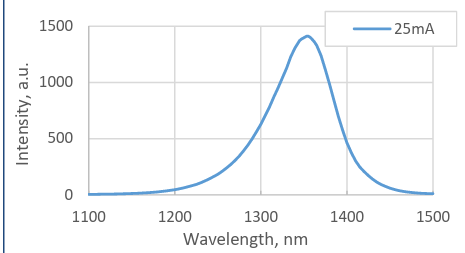

Since the LUCAS dataset already provides normalized reflectance/absorbance intensities across wavelengths, we can simulate the response of a LED-based spectrometer by projecting each soil spectrum onto the emission profile of every LED. Concretely, this is done by multiplying the spectrum with the LED’s normalized emission curve and integrating over wavelength. The result is a single scalar “channel response” per LED, and concatenating these channel responses yields the simulated multispectral measurement.

More formally:

We simulated LED multispectral measurements by projecting each LUCAS spectrum onto area-normalized LED emission profiles, i.e. given:

- **$c_{i,k}$** : Simulated channel response for sample $i$ under LED $k$ (one scalar).
- **$R_i(\lambda_m)$** : Reflectance (or absorbance) spectrum of sample $i$ at discrete wavelength $\lambda_m$ (from LUCAS).
- **$L_k(\lambda_m)$** : Area-normalized emission profile of LED $k$ evaluated at $\lambda_m$.
- **$D(\lambda_m)$** : Detector responsivity at wavelength $\lambda_m$ (default $D(\lambda_m)=1$ if omitted).
- **$\lambda_m$** : Discrete wavelength grid points (nanometers).
- **$\Delta\lambda$** : Grid spacing between consecutive wavelengths.
- **$K$** : Total number of LEDs. Concatenating all $c_{i,k}$ for a sample $i$ yields a $K$-dimensional multispectral vector.

---

The discrete Riemann sum formulation is:

$[
c_{i,k} \;\approx\; \sum_{m=1}^{M} R_i(\lambda_m)\,L_k(\lambda_m)\,D(\lambda_m)\,\Delta\lambda
]$

where $M$ is the total number of wavelength samples.

We choose to omit any detector responsivity, second order optical phenomena and any hardware noise terms by either not including them in our model or setting them to one. Our primary goal is to show a discrete spectra can produce actionable and reliable results for the farmer. A great next step would be to study the effects of noise, and second order terms on the model's efficacy.

We also area-normalize each LED Gaussian because this ensures that every LED spectrum acts as a pure weighting function (integral = 1), so the resulting channel responses reflect only the sample’s spectral shape rather than being biased by the LED’s bandwidth or peak height.



In [ ]:


EPS = 1e-12

# LED definitions to construct LED spectrum gaussians
@dataclass
class LEDSpec:
    name: str
    center_nm: float
    fwhm_nm: float

def vis_nir_led_bank() -> List[LEDSpec]:
    return [
        LEDSpec("VIS520", 520.0, 30.0),  LEDSpec("VIS550", 550.0, 30.0),
        LEDSpec("VIS590", 590.0, 25.0),  LEDSpec("VIS625", 625.0, 20.0),
        LEDSpec("VIS660", 660.0, 25.0),  LEDSpec("NIR730", 730.0, 20.0),
        LEDSpec("NIR740", 740.0, 20.0),  LEDSpec("NIR760", 760.0, 22.0),
        LEDSpec("NIR780", 780.0, 25.0),  LEDSpec("NIR808", 808.0, 30.0),
        LEDSpec("NIR850", 850.0, 35.0),  LEDSpec("NIR880", 880.0, 35.0),
        LEDSpec("NIR905", 905.0, 40.0),  LEDSpec("NIR940", 940.0, 45.0),
        LEDSpec("NIR970", 970.0, 50.0),  LEDSpec("NIR980", 980.0, 50.0),
        LEDSpec("NIR1000", 1000.0, 50.0),
    ]

def lms_led_bank() -> List[LEDSpec]:
    return [
        LEDSpec("Lms10LED", 1050.0, 40.0),
        LEDSpec("Lms13LED", 1290.0, 85.0),
        LEDSpec("Lms14LED", 1445.0, 105.0),
        LEDSpec("Lms15LED (approx)", 1545.0, 130.0),
        LEDSpec("Lms1550LED (approx)", 1550.0, 130.0),
        LEDSpec("Lms16LED (approx)", 1645.0, 145.0),
        LEDSpec("Lms17LED (approx)", 1745.0, 155.0),
        LEDSpec("Lms18LED (approx)", 1845.0, 170.0),
        LEDSpec("Lms19LED (approx)", 1945.0, 185.0),
        LEDSpec("Lms20LED", 2045.0, 200.0),
        LEDSpec("Lms21LED (approx)", 2145.0, 210.0),
        LEDSpec("Lms22LED (approx)", 2245.0, 215.0),
        LEDSpec("Lms23LED", 2345.0, 220.0),
    ]

ALL_LEDS = [*vis_nir_led_bank(), *lms_led_bank()]
LED_NAMES = [led.name for led in ALL_LEDS]

# _gaussian and build_area_normalized_leds generate a Gaussian emission profile for a given LED.
# Each profile is area-normalized (∫=1) so it acts purely as a weighting function
# on the input spectrum. This prevents LEDs with broader or narrower bandwidths
# from producing disproportionately large responses, ensuring that the simulated
# LED channels remain comparable when applied to the already normalized LUCAS spectra.
def _gaussian(wl_nm: np.ndarray, mu: float, fwhm: float) -> np.ndarray:
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    return np.exp(-0.5 * ((wl_nm - mu) / (sigma + 1e-12))**2)

def build_area_normalized_leds(
    wl_nm: np.ndarray,
    leds: List[LEDSpec] = ALL_LEDS
) -> Tuple[np.ndarray, List[str]]:
    curves, names = [], []
    for led in leds:
        g = _gaussian(wl_nm, led.center_nm, led.fwhm_nm)
        g /= (np.trapezoid(g, wl_nm) + EPS)
        curves.append(g.astype(np.float32))
        names.append(led.name)
    B_area = np.vstack(curves)  # (K, nλ)
    return B_area, names

# Discretization function
def simulate_led_channels(
    X_reflectance: np.ndarray,
    wl_nm: np.ndarray,
    B_area: np.ndarray,
    detector_resp: Optional[np.ndarray] = None
) -> np.ndarray:
    B = B_area if detector_resp is None else (B_area * detector_resp[None, :])
    dlam = float(np.mean(np.diff(wl_nm)))
    return (X_reflectance @ B.T * dlam).astype(np.float32)


X_train: (42615, 30) | X_val: (2179, 30) | X_test: (2179, 30)
LED channels: 30 ['VIS520', 'VIS550', 'VIS590', 'VIS625', 'VIS660'] ...


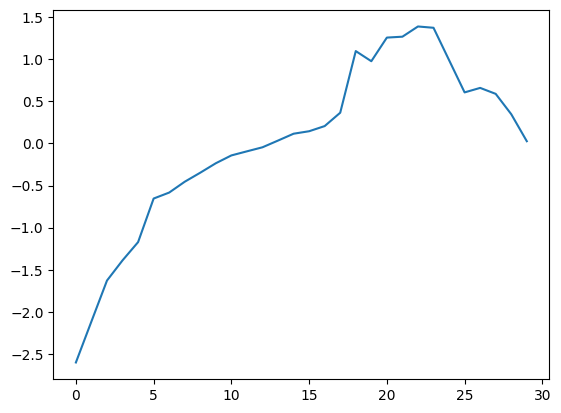

In [ ]:
# Final preprocessing of all model related data, LED degrade the X and log transform N
def process_X(X_in):
    #  LED sim -> R->A -> SNV
    wl_keep = np.linspace(500.0, 2499.5, X_in.shape[1], dtype=np.float32)
    B_area, led_names = build_area_normalized_leds(wl_keep)
    X_led = simulate_led_channels(X, wl_keep, B_area)



    X_abs = reflectance_to_absorbance(X_led)
    X_snv = standard_normal_variate_rows(X_abs)
    return X_snv, led_names

X_train, led_names = process_X(X_train_aug)
X_val,   _         = process_X(X_val)
X_test,  _         = process_X(X_test)
plt.plot(X_train[0])

N_train = np.log1p(N_train_aug)
N_val   = np.log1p(N_val)
N_test  = np.log1p(N_test)

print("X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)
print("LED channels:", len(led_names), led_names[:5], "...")

Train: (42615, 30), Val: (2179, 30), Test: (2179, 30), Tab=2

===== Fold 1/5 =====
Epoch 1/250
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4688 - mae: 1.4980
Epoch 1: val_loss improved from inf to 0.64368, saving model to best_fold_1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.4582 - mae: 1.4677 - val_loss: 0.6437 - val_mae: 2.0029 - learning_rate: 0.0025
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1303 - mae: 0.5208
Epoch 2: val_loss improved from 0.64368 to 0.29255, saving model to best_fold_1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1301 - mae: 0.5203 - val_loss: 0.2926 - val_mae: 0.9929 - learning_rate: 0.0025
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1096 - mae: 0.4580
Epoch 3: val_loss improved from 0.29255 to 0.16704, saving model to best_fold_1.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1096 - mae: 0.4577 - val_loss: 0.1670 - val_mae: 0.6325 - learning_rate: 0.0025
Epoch 4/250
34/34 ━━━━━━━━━━━━

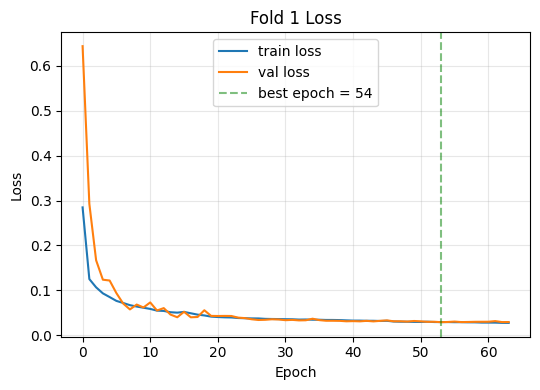


===== Fold 2/5 =====
Epoch 1/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4891 - mae: 1.5557
Epoch 1: val_loss improved from inf to 0.42123, saving model to best_fold_2.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.4837 - mae: 1.5401 - val_loss: 0.4212 - val_mae: 1.3686 - learning_rate: 0.0025
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1221 - mae: 0.4950
Epoch 2: val_loss improved from 0.42123 to 0.12903, saving model to best_fold_2.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1219 - mae: 0.4944 - val_loss: 0.1290 - val_mae: 0.5107 - learning_rate: 0.0025
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1005 - mae: 0.4296
Epoch 3: val_loss did not improve from 0.12903
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1004 - mae: 0.4295 - val_loss: 0.1658 - val_mae: 0.6305 - learning_rate: 0.0025
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0861 - mae: 0.3857
Epoch 4: val_loss improved from 0.12903 to 0.1138

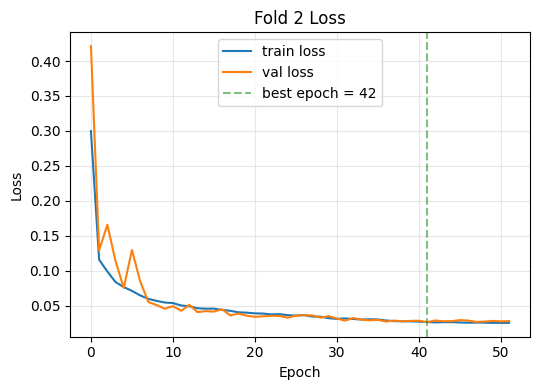


===== Fold 3/5 =====
Epoch 1/250
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4440 - mae: 1.4261
Epoch 1: val_loss improved from inf to 0.59156, saving model to best_fold_3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.4339 - mae: 1.3969 - val_loss: 0.5916 - val_mae: 1.8502 - learning_rate: 0.0025
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1191 - mae: 0.4859
Epoch 2: val_loss improved from 0.59156 to 0.17824, saving model to best_fold_3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1189 - mae: 0.4853 - val_loss: 0.1782 - val_mae: 0.6623 - learning_rate: 0.0025
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1003 - mae: 0.4279
Epoch 3: val_loss improved from 0.17824 to 0.10801, saving model to best_fold_3.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1002 - mae: 0.4278 - val_loss: 0.1080 - val_mae: 0.4515 - learning_rate: 0.0025
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0897 - mae: 0.3956
Epoch 4: 

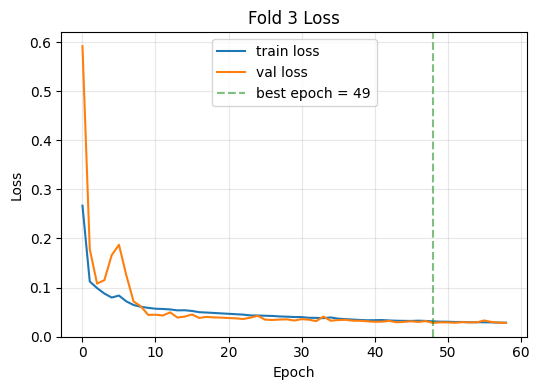


===== Fold 4/5 =====
Epoch 1/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3710 - mae: 1.2180
Epoch 1: val_loss improved from inf to 0.16183, saving model to best_fold_4.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.3673 - mae: 1.2073 - val_loss: 0.1618 - val_mae: 0.6151 - learning_rate: 0.0025
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1267 - mae: 0.5091
Epoch 2: val_loss did not improve from 0.16183
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1265 - mae: 0.5085 - val_loss: 0.1945 - val_mae: 0.7136 - learning_rate: 0.0025
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1052 - mae: 0.4453
Epoch 3: val_loss did not improve from 0.16183
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1052 - mae: 0.4451 - val_loss: 0.1707 - val_mae: 0.6439 - learning_rate: 0.0025
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0923 - mae: 0.4061
Epoch 4: val_loss improved from 0.16183 to 0.11735, saving model to best_fold_4.keras
34

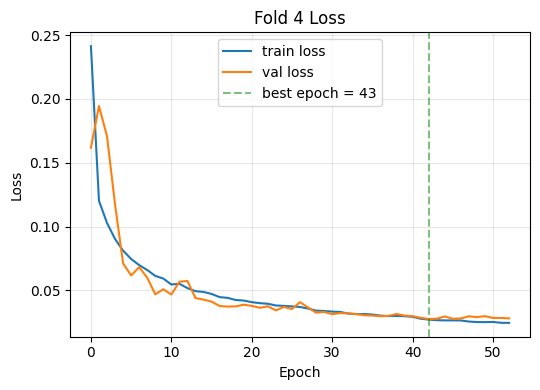


===== Fold 5/5 =====
Epoch 1/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4915 - mae: 1.5624
Epoch 1: val_loss improved from inf to 0.43744, saving model to best_fold_5.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.4859 - mae: 1.5464 - val_loss: 0.4374 - val_mae: 1.4031 - learning_rate: 0.0025
Epoch 2/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1186 - mae: 0.4848
Epoch 2: val_loss improved from 0.43744 to 0.30698, saving model to best_fold_5.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1184 - mae: 0.4842 - val_loss: 0.3070 - val_mae: 1.0273 - learning_rate: 0.0025
Epoch 3/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1000 - mae: 0.4274
Epoch 3: val_loss improved from 0.30698 to 0.17890, saving model to best_fold_5.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0999 - mae: 0.4272 - val_loss: 0.1789 - val_mae: 0.6657 - learning_rate: 0.0025
Epoch 4/250
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0910 - mae: 0.3999
Epoch 4: v

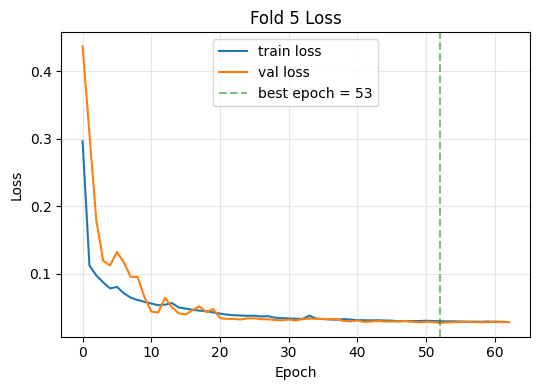


Average across 5 folds — val_loss: 0.027742 | val_mae: 0.186364

Best fold: 2 (val_loss=0.026480)
Loading checkpoint: best_fold_2.keras

Test — LOSS (log): 0.024577 | MAE (log): 0.174447
Test (log) — RMSE: 0.232574 | R²: 0.826254

RAW Test — RMSE: 1.4063 | R²: 0.8608 | RPD: 2.681 | RPIQ: 1.493
Mean Percentage Accuracy: 69.59%


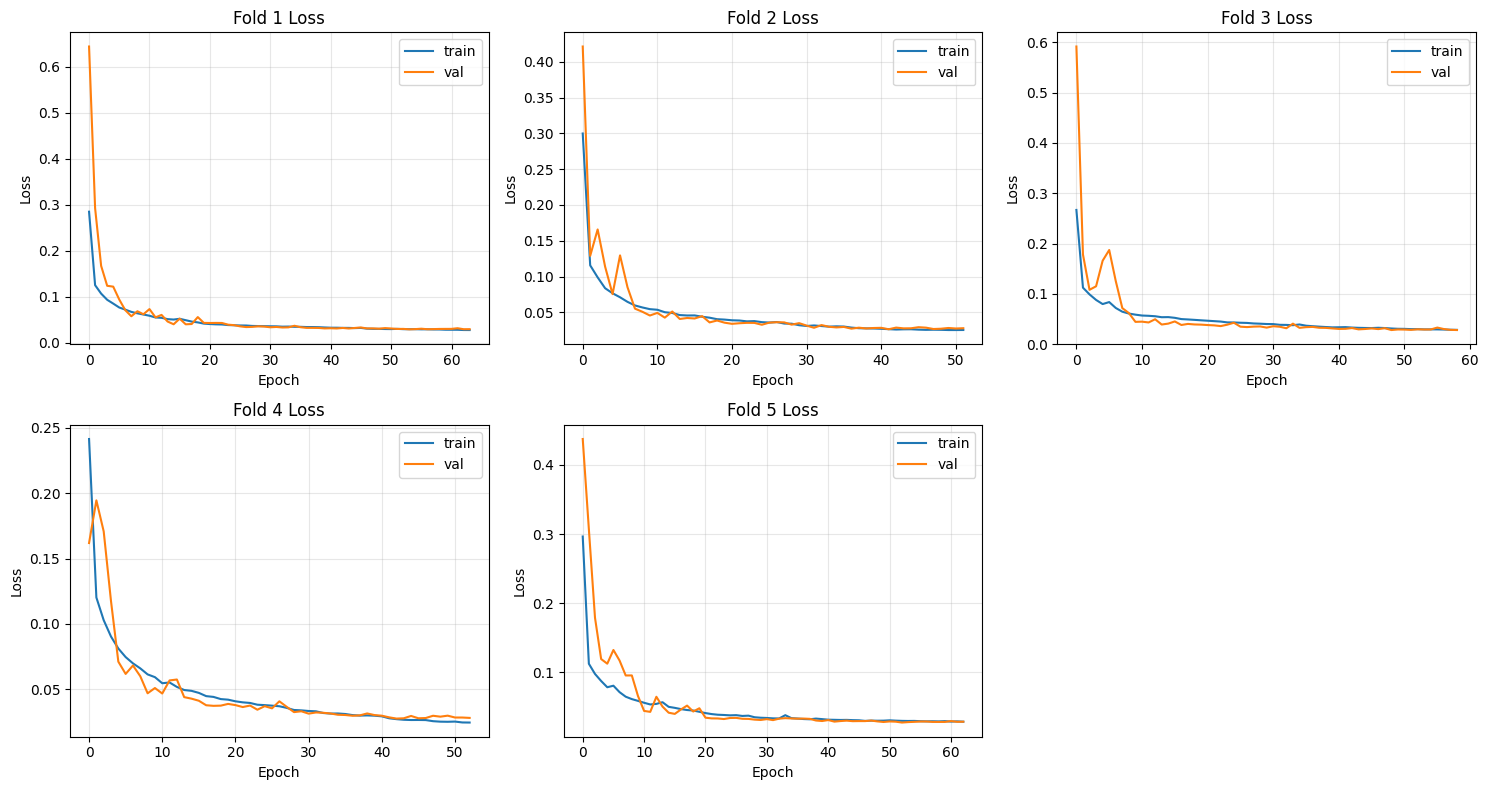

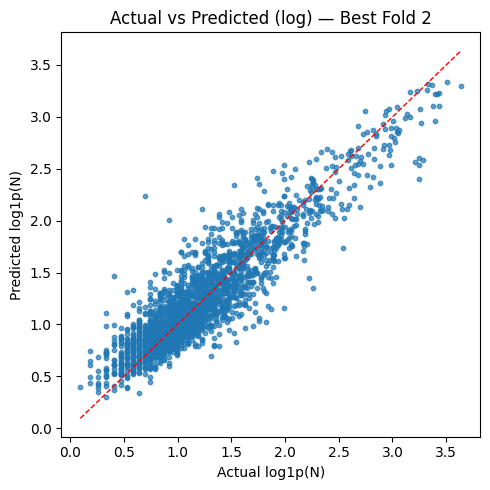

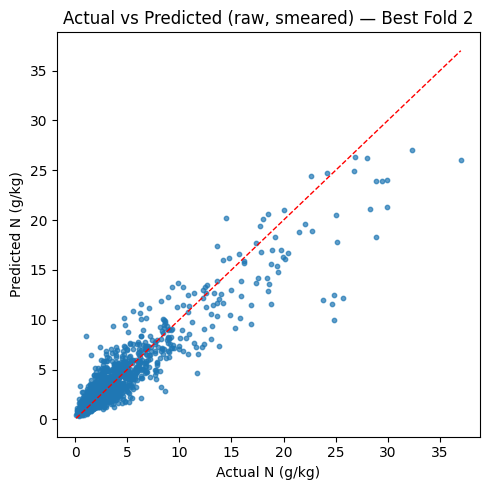


Per-bin exact classification accuracy:
     Bin       n      Acc%
     0-2    1066     82.83
     2-5     822     69.95
    5-10     192     63.02
   10-20      73     67.12
     20+      26     53.85


In [ ]:
#  Bidirectional GRU + CNN + Scalar Fusion (EC,pH) + Regression head
#  5-fold CV on TRAIN (aug), fixed VAL, pick best fold by val_loss, Test Eval
#  Per-fold loss plot after each fold + overall loss plots at the end
#  per-bucket accuracy (including 20+ bin)

# Hyperparameters
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

BATCH_SIZE   = 1024
LR           = 2.5e-3
WEIGHT_DECAY = 1e-4
EPOCHS       = 250
FOLDS        = 5
LOSS         = tf.keras.losses.Huber(delta=0.352)
EPS          = 1e-8


BINS   = [0, 2, 5, 10, 20, np.inf]
LABELS = ["0-2", "2-5", "5-10", "10-20", "20+"]

# Assemble input and output data as the model expects
X_train_all = X_train.astype(np.float32)
y_train_all = N_train.astype(np.float32).ravel()
Z_train_all = np.column_stack([EC_train_aug, pH_train_aug]).astype(np.float32)

X_val_all   = X_val.astype(np.float32)
y_val_all   = N_val.astype(np.float32).ravel()
Z_val_all   = np.column_stack([EC_val, pH_val]).astype(np.float32)

X_test_all  = X_test.astype(np.float32)
y_test_all  = N_test.astype(np.float32).ravel()
Z_test_all  = np.column_stack([EC_test, pH_test]).astype(np.float32)

N_train_rows, K = X_train_all.shape
NT = Z_train_all.shape[1]
print(f"Train: {X_train_all.shape}, Val: {X_val_all.shape}, Test: {X_test_all.shape}, Tab={NT}")

# Model
# Inputs: preprocessed LED signal, EC, pH
# Output: log1p(Nitorgen)

def BiGRU_CNN_TabFusion(seq_len: int, num_tab: int, gru_units: int = 64) -> tf.keras.Model:
    led_in = L.Input(shape=(seq_len,), name="led_vector")
    tab_in = L.Input(shape=(num_tab,), name="tabular")

    # Normalizers for training stability
    norm_led = L.Normalization(name="norm_led")
    norm_tab = L.Normalization(name="norm_tab")

    # Spectral sequence path
    x = norm_led(led_in)
    x = L.Reshape((seq_len, 1))(x)

    # Bidirectional GRU takes LED signal
    x = L.Bidirectional(
        L.GRU(gru_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.0),
        merge_mode="concat"
    )(x)
    x = L.LayerNormalization(axis=-1, name="ln_after_biGRU")(x)

    # Conv stack (BN -> GELU)
    x = L.Conv1D(64, 3, padding="same", kernel_initializer="he_normal")(x)
    x = L.BatchNormalization()(x); x = L.Activation("gelu")(x)

    x = L.Conv1D(128, 3, padding="same", kernel_initializer="he_normal")(x)
    x = L.BatchNormalization()(x); x = L.Activation("gelu")(x)

    x = L.Conv1D(192, 3, padding="same", kernel_initializer="he_normal")(x)
    x = L.BatchNormalization()(x); x = L.Activation("gelu")(x)

    x = L.GRU(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.0)(x)
    x = L.LayerNormalization(axis=-1, name="ln_after_final_GRU")(x)

    # Scalar Inputs EC and pH
    t = norm_tab(tab_in)
    t = L.Dense(32, kernel_initializer="he_normal")(t)
    t = L.BatchNormalization()(t); t = L.Activation("gelu")(t)

    # Fusion and Regression
    h = L.Concatenate(name="fusion")([x, t])
    h = L.Dense(160, kernel_initializer="he_normal")(h)
    h = L.BatchNormalization()(h); h = L.Activation("gelu")(h)
    h = L.Dense(80, kernel_initializer="he_normal")(h)
    h = L.BatchNormalization()(h); h = L.Activation("gelu")(h)
    h = L.Dropout(0.2)(h)

    out = L.Dense(1, activation="linear", name="y_hat")(h)

    opt = tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY)
    model = Model(inputs=[led_in, tab_in], outputs=out, name="BiGRU_CNN_TabFusion")
    model.compile(optimizer=opt, loss=LOSS, metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

# 5-fold CV
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_scores, fold_histories, fold_ckpts = [], [], []

for fold_idx, (tr_idx, _) in enumerate(kf.split(X_train_all), start=1):
    print(f"\n===== Fold {fold_idx}/{FOLDS} =====")
    X_tr, y_tr, Z_tr = X_train_all[tr_idx], y_train_all[tr_idx], Z_train_all[tr_idx]

    model = BiGRU_CNN_TabFusion(seq_len=K, num_tab=NT, gru_units=64)

    # Adapt normalizers
    model.get_layer("norm_led").adapt(X_tr)
    model.get_layer("norm_tab").adapt(Z_tr)

    ckpt_path = f"best_fold_{fold_idx}.keras"
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    ]

    hist = model.fit(
        [X_tr, Z_tr], y_tr,
        validation_data=([X_val_all, Z_val_all], y_val_all),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    # Store history
    fold_histories.append(hist.history)
    fold_ckpts.append(ckpt_path)

    # Evaluate best checkpoint on val
    best_fold = tf.keras.models.load_model(ckpt_path, compile=False)
    best_fold.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
        loss=LOSS, metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    val_loss, val_mae = best_fold.evaluate([X_val_all, Z_val_all], y_val_all, verbose=0)
    fold_scores.append({"fold": fold_idx, "val_loss": float(val_loss), "val_mae": float(val_mae)})
    print(f"Fold {fold_idx} — val_loss: {val_loss:.6f} | val_mae: {val_mae:.6f}")

    # Per-fold loss plot
    tr = hist.history.get("loss", [])
    va = hist.history.get("val_loss", [])
    best_epoch = int(np.argmin(va)) + 1 if len(va) else None

    plt.figure(figsize=(5.5, 4.0))
    plt.plot(tr, label="train loss")
    plt.plot(va, label="val loss")
    if best_epoch is not None:
        plt.axvline(best_epoch-1, color='g', linestyle='--', alpha=0.5, label=f"best epoch = {best_epoch}")
    plt.title(f"Fold {fold_idx} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.show()

# Summary of folds
avg_val_loss = float(np.mean([s["val_loss"] for s in fold_scores]))
avg_val_mae  = float(np.mean([s["val_mae"]  for s in fold_scores]))
print(f"\nAverage across {FOLDS} folds — val_loss: {avg_val_loss:.6f} | val_mae: {avg_val_mae:.6f}")

# Pick best fold and test it
best_fold_idx = int(np.argmin([s["val_loss"] for s in fold_scores]))
best_fold_id  = fold_scores[best_fold_idx]["fold"]
best_ckpt     = fold_ckpts[best_fold_idx]
print(f"\nBest fold: {best_fold_id} (val_loss={fold_scores[best_fold_idx]['val_loss']:.6f})")
print(f"Loading checkpoint: {best_ckpt}")

best_model = tf.keras.models.load_model(best_ckpt, compile=False)
best_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
    loss=LOSS, metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

# Test (log scale)
test_loss, test_mae = best_model.evaluate([X_test_all, Z_test_all], y_test_all, verbose=0)
print(f"\nTest — LOSS (log): {test_loss:.6f} | MAE (log): {test_mae:.6f}")

y_pred_log = best_model.predict([X_test_all, Z_test_all], verbose=0).ravel()
rmse_log = float(np.sqrt(mean_squared_error(y_test_all, y_pred_log)))
r2_log   = float(r2_score(y_test_all, y_pred_log))
print(f"Test (log) — RMSE: {rmse_log:.6f} | R²: {r2_log:.6f}")

# Back-transform to raw scale with Duan smearing (based on VAL)
y_val_pred_log = best_model.predict([X_val_all, Z_val_all], verbose=0).ravel()
resid_val = y_val_all - y_val_pred_log
smear_k = float(np.mean(np.exp(resid_val)))  # Duan smearing factor

y_test_real = np.expm1(y_test_all)
y_pred_real = (np.exp(y_pred_log) * smear_k) - 1.0

# Metrics on RAW scale (use these for RPD)
rmse_raw = float(np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
r2_raw   = float(r2_score(y_test_real, y_pred_real))
sy_raw   = float(np.std(y_test_real, ddof=1))               # std on the SAME set
rpd_raw  = float(sy_raw / (rmse_raw + EPS))
rpiq_raw = float((np.percentile(y_test_real,75)-np.percentile(y_test_real,25)) / (rmse_raw + EPS))

mape = float(np.mean(np.abs((y_test_real - y_pred_real) / (y_test_real + EPS))))
mean_percentage_accuracy = 100.0 * (1.0 - mape)

print(f"\nRAW Test — RMSE: {rmse_raw:.4f} | R²: {r2_raw:.4f} | RPD: {rpd_raw:.3f} | RPIQ: {rpiq_raw:.3f}")
print(f"Mean Percentage Accuracy: {mean_percentage_accuracy:.2f}%")

# Overall loss plots
cols = 3
rows = int(np.ceil(FOLDS / cols))
plt.figure(figsize=(cols*5, rows*4))
for i, hist in enumerate(fold_histories, start=1):
    plt.subplot(rows, cols, i)
    tr = hist.get("loss", [])
    va = hist.get("val_loss", [])
    plt.plot(tr, label="train")
    plt.plot(va, label="val")
    plt.title(f"Fold {i} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# Parity Plot (log nitrogen)
plt.figure(figsize=(5,5))
plt.scatter(y_test_all, y_pred_log, s=10, alpha=0.7)
mn, mx = np.min([y_test_all, y_pred_log]), np.max([y_test_all, y_pred_log])
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.xlabel("Actual log1p(N)")
plt.ylabel("Predicted log1p(N)")
plt.title(f"Actual vs Predicted (log) — Best Fold {best_fold_id}")
plt.tight_layout()
plt.show()

# Parity Plot (raw nitrogen)
plt.figure(figsize=(5,5))
plt.scatter(y_test_real, y_pred_real, s=10, alpha=0.7)
mn, mx = np.min([y_test_real, y_pred_real]), np.max([y_test_real, y_pred_real])
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.xlabel("Actual N (g/kg)")
plt.ylabel("Predicted N (g/kg)")
plt.title(f"Actual vs Predicted (raw, smeared) — Best Fold {best_fold_id}")
plt.tight_layout()
plt.show()

# Bucketed per-bin accuracy for raw nitrogen
def bucket_indices(y, bins):
    edges = np.asarray(bins, dtype=float)
    return np.searchsorted(edges, y, side='right') - 1

# Indices for true and predicted bins
true_bins = bucket_indices(y_test_real, np.array(BINS))
pred_bins = bucket_indices(y_pred_real, np.array(BINS))
pred_bins = np.clip(pred_bins, 0, len(LABELS)-1)

# Keep only samples whose true bin is valid (0..len(LABELS)-1)
valid_true_mask = (true_bins >= 0) & (true_bins < len(LABELS))
tb = true_bins[valid_true_mask]
pb = pred_bins[valid_true_mask]
y_true_in = y_test_real[valid_true_mask]
y_pred_in = y_pred_real[valid_true_mask]

# Per-bin accuracy: P( predicted bin == true bin | true bin = b )
print("\nPer-bin exact classification accuracy:")
print(f"{'Bin':>8}  {'n':>6}  {'Acc%':>8}")
for b, lab in enumerate(LABELS):
    m = (tb == b)
    n = int(np.sum(m))
    if n == 0:
        acc = np.nan
    else:
        acc = float(np.mean(pb[m] == tb[m])) * 100.0
    print(f"{lab:>8}  {n:6d}  {acc:8.2f}")


In [ ]:
#Results

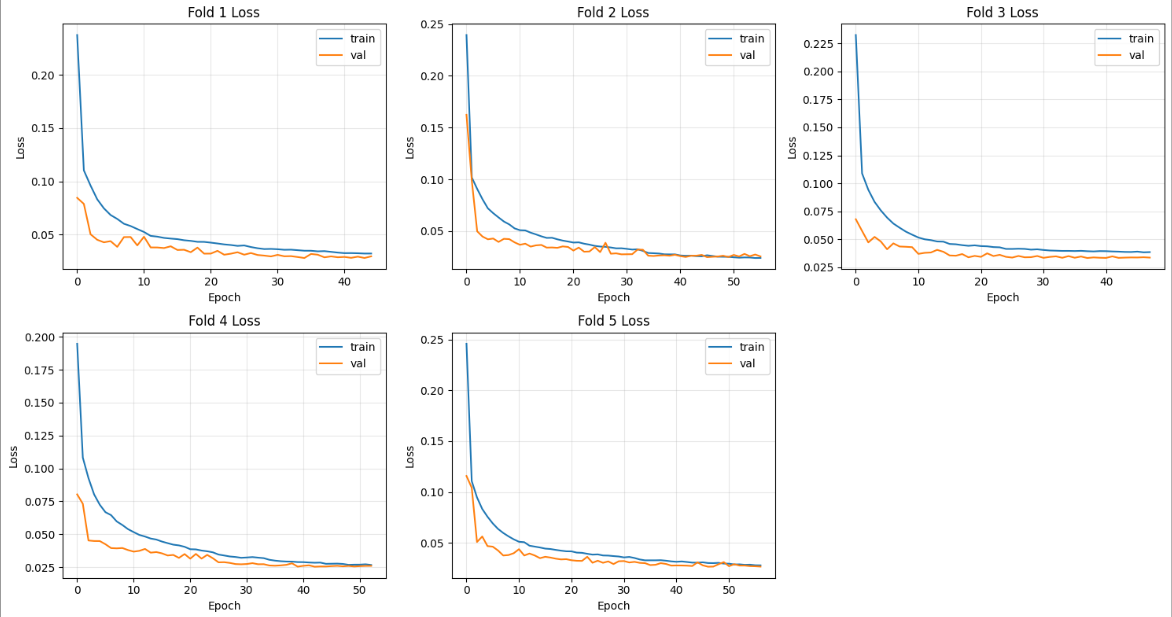

These are the respective training and validation loss curves after 5 folds of training. We observe that each fold shows no sign of over or underfitting, with smooth convergence of both the validation and training loss curves.

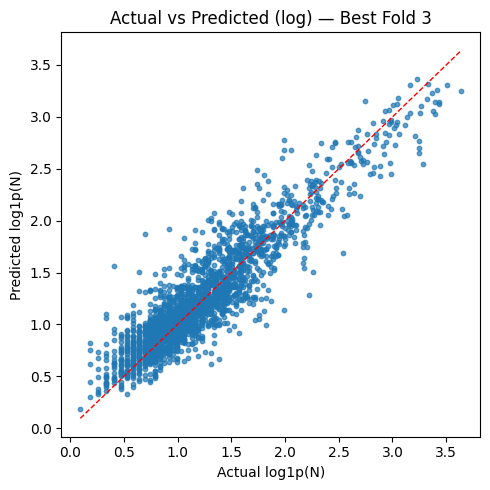


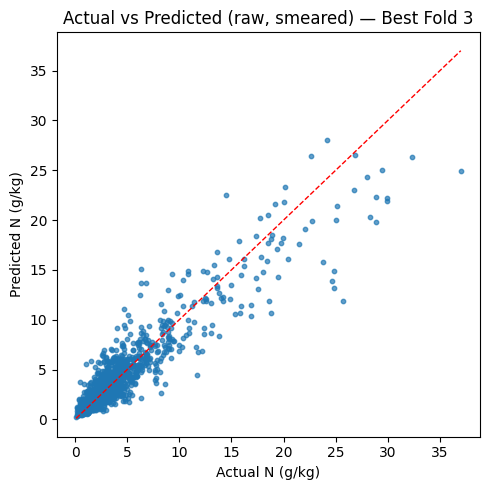




### Per-bin exact regression accuracy

| Bin   |   n   |  Acc % |
|-------|-------|--------|
| 0–2   | 1066  | 84.05  |
| 2–5   |  822  | 71.78  |
| 5–10  |  192  | 69.27  |
| 10–20 |   73  | 69.86  |
| 20+   |   26  | 57.69  |






### Test Results (log N)

| Metric | Value    |
|--------|----------|
| LOSS   | 0.022846 |
| MAE    | 0.168573 |
| RMSE   | 0.226608 |
| R²     | 0.835054 |



### RAW Test Results

| Metric | Value  |
|--------|--------|
| RMSE   | 1.3877 |
| R²     | 0.8645 |
| RPD    | 2.717  |
| RPIQ   | 1.513  |


Mean Percentage Accuracy: 70.43%